In [43]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import sqlite3

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

Using Device: cuda


In [45]:
# Step 1: Load & preprocess the data
file_path = "random_data.db"
conn  = sqlite3.connect(file_path)
query = "SELECT * FROM sales_data"
df = pd.read_sql_query(query, conn)
conn.close()

# Keep only the required columns
df = df[['District', 'Product_Brand', 'Brand_Flavour', 'Billing_Date', 'Sum_of_Billed_Quantity']]
df.dropna(inplace=True)
df['Billing_Date'] = pd.to_datetime(df['Billing_Date'])
df.sort_values('Billing_Date', inplace=True)

# Encode categorical variables
for col in ['District', 'Product_Brand', 'Brand_Flavour']:
    df[col] = LabelEncoder().fit_transform(df[col])

# Create time-based features
df['year'] = df['Billing_Date'].dt.year
df['month'] = df['Billing_Date'].dt.month
df['day'] = df['Billing_Date'].dt.day

# Drop the original date column
df.drop('Billing_Date', axis=1, inplace=True)

# Scale features
scaler = MinMaxScaler()
features = df.drop('Sum_of_Billed_Quantity', axis=1)
features_scaled = scaler.fit_transform(features)
target = df['Sum_of_Billed_Quantity'].values

In [46]:
# Step 2: Create sequences for LSTM
def create_sequences(X, y, window_size=10):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    
    return torch.tensor(np.array(Xs), dtype=torch.float32), torch.tensor(np.array(ys), dtype=torch.float32)

In [47]:
window_size = 10
X_seq, y_seq = create_sequences(features_scaled, target, window_size)

# Train/test split
train_size = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]


In [48]:
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

In [49]:
# Step 3: Define LSTM model
class SalesLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(SalesLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # use last time step
        out = self.fc(out)
        return out.squeeze()

In [50]:
# Model setup
model = SalesLSTM(input_size=X_train.shape[2])
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=4e-2)

In [51]:
# Training loop
epochs = 180
for epoch in range(epochs):
    a = val_loss.item()
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_pred = model(X_test)
        val_loss = criterion(val_pred, y_test)
    if( a < val_loss.item()): break
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

Epoch 1/180 - Train Loss: 13390.9014 - Val Loss: 13162.1084
Epoch 2/180 - Train Loss: 13019.0039 - Val Loss: 12759.2061
Epoch 3/180 - Train Loss: 12575.2910 - Val Loss: 12474.0400
Epoch 4/180 - Train Loss: 12291.4932 - Val Loss: 12204.5781
Epoch 5/180 - Train Loss: 12024.6621 - Val Loss: 11940.5439
Epoch 6/180 - Train Loss: 11763.2080 - Val Loss: 11685.2783
Epoch 7/180 - Train Loss: 11510.4482 - Val Loss: 11434.4648
Epoch 8/180 - Train Loss: 11262.4160 - Val Loss: 11186.5820
Epoch 9/180 - Train Loss: 11017.4580 - Val Loss: 10941.3604
Epoch 10/180 - Train Loss: 10775.2451 - Val Loss: 10699.0693
Epoch 11/180 - Train Loss: 10536.0039 - Val Loss: 10460.0811
Epoch 12/180 - Train Loss: 10300.0869 - Val Loss: 10224.7285
Epoch 13/180 - Train Loss: 10067.8174 - Val Loss: 9993.2930
Epoch 14/180 - Train Loss: 9839.4648 - Val Loss: 9765.9951
Epoch 15/180 - Train Loss: 9615.2529 - Val Loss: 9543.0195
Epoch 16/180 - Train Loss: 9395.3574 - Val Loss: 9324.5098
Epoch 17/180 - Train Loss: 9179.9199 - V

In [52]:
# Step 4: Evaluate model
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
y_pred = y_pred.to('cpu')
y_test = y_test.to('cpu')
rmse = np.sqrt(mean_squared_error(y_test, y_pred.numpy()))
print("Test RMSE:", rmse)

Test RMSE: 57.46247501766914


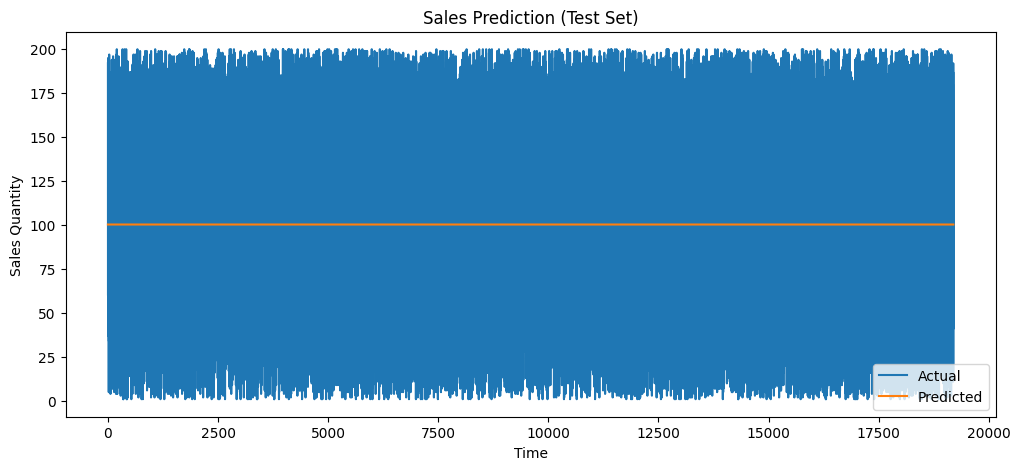

In [53]:
# Optional: Plot predictions
plt.figure(figsize=(12, 5))
plt.plot(y_test.numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Sales Prediction (Test Set)")
plt.xlabel("Time")
plt.ylabel("Sales Quantity")
plt.legend()
plt.show()

In [ ]:
def generate_future_predictions(model, input_seq, n_future, device='cpu'):
    model.eval()
    predictions = []

    curr_input = input_seq.clone().detach().to(device)  # shape: (1, window_size, num_features)

    with torch.no_grad():
        for _ in range(n_future):
            pred = model(curr_input)  # shape: (1, 1)
            predictions.append(pred.item())

            # Append prediction and remove oldest input to slide window
            new_input = curr_input[:, 1:, :].clone()  # drop first time step
            new_pred_feature = torch.zeros_like(curr_input[:, -1:, :])
            new_pred_feature[:, :, 0] = pred  # assume the target is at index 0

            # Optional: you may copy over categorical features from the last input step
            new_pred_feature[:, :, 1:] = curr_input[:, -1:, 1:]

            curr_input = torch.cat([new_input, new_pred_feature], dim=1)

    return predictions


In [ ]:
# Assume 'X_test' is the test input sequence (last window of shape (1, window_size, num_features))
n_future = 30  # days to forecast
future_preds = generate_future_predictions(model, X_test, n_future, device=device)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(future_preds, label='Future Predictions')
plt.title("30-Day Sales Forecast")
plt.xlabel("Day")
plt.ylabel("Predicted Sales Quantity")
plt.legend()
plt.show()
